In [1]:
#%pip install git+https://github.com/gbdrt/mu-ppl

In [2]:
from mu_ppl import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Exercices

**Question 1**

Define a probabilistic program that models the number of tosses of a fair coin before getting a Tail.

100%|██████████| 10000/10000 [00:00<00:00, 676173.46it/s]


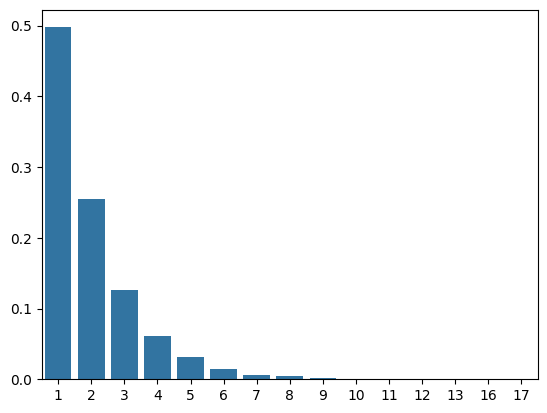

In [3]:
def success(n):
    flip = sample(Bernoulli(0.5))
    if flip:
        return n
    return success(n+1)


with ImportanceSampling(num_particles=10000):
    dist: Empirical[int] = infer(success, 1)
    viz(dist) 



**Question 2**

Knuth and Yao proposed an algorithm that allows simulating a perfect 6-sided die from a fair coin. 
The algorithm corresponds to the discrete Markov chain represented below.

![knuth-yao](./knuth-yao.jpg)

Starting from the initial state, we follow the transitions based on the result of a coin toss (probability 0.5 on each of the two branches). 
We return the value obtained as soon as we reach a leaf. 
The 6 leaves numbered from 11 to 16 correspond to the 6 faces of the die.

_D. Knuth and A. Yao. Algorithms and Complexity: New Directions and Recent Results, chapter The complexity of nonuniform random number generation. Academic Press, 1976.) proposed an algorithm that allows simulating a perfect 6-sided die from a fair coin [1]. The algorithm corresponds to the discrete Markov chain represented below._

Implement this model and verify that we indeed obtain a balanced die.

100%|██████████| 100000/100000 [00:00<00:00, 298165.99it/s]


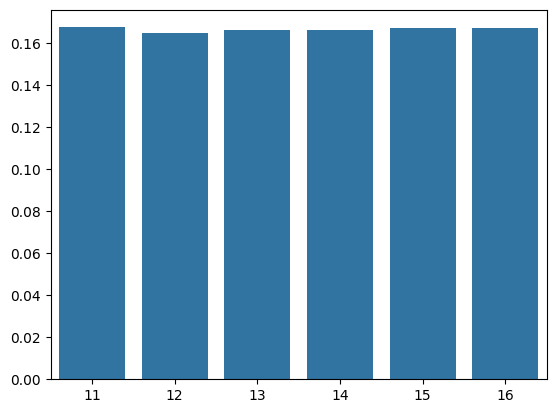

In [4]:
def dice ():
  def gen(x):
    c = sample(Bernoulli(0.5))
    match x:
      case 0:
        return gen(1 if c else 2)
      case 1:
        return gen(3 if c else 4)
      case 2:
        return gen(5 if c else 6)
      case 3:
        return gen(1 if c else 11)
      case 4:
        return gen(12 if c else 13)
      case 5:
        return gen(14 if c else 15)
      case 6:
        return gen(16 if c else 2)
      case _:
        return x
  return gen(0)
  
with ImportanceSampling(num_particles=100000):
  dist: Empirical[int] = infer(dice)
  viz(dist) 


**Question 3**

TrueSkills™ is a ranking system developed by Microsoft for Xbox Live.
Each player's skill level is represented by a Gaussian distribution. 
We initially assume that for all players P, skill_P ∼ N(100, 10).
In each duel, the performance of each player follows a Gaussian distribution centered on their skill level with a fixed variance. 
We then observe that the performance of the winner W is superior to that of the loser L, which updates the random variables skill_W and skill_L.

```
perf_W ∼ N(skill_W, 15)
perf_L ∼ N(skill_L, 15)
perf_W > perf_L
```

_R. Herbrich, T. Minka and T. Graepel TrueSkill™: A Bayesian Skill Rating System. NIPS, 2006._

Implement this model for three players A, B, and C, and three duels:

```
A wins against B,
B wins against C,
A wins against C.
```

Verify that the obtained results correspond to what we expect.



In [43]:
def true_skills() -> list[float]:
    skill_a = sample(Gaussian(100., 10.))
    skill_b = sample(Gaussian(100., 10.))
    skill_c = sample(Gaussian(100., 10.))
    
    # A vs B (A wins)
    perf_a1 = sample(Gaussian(skill_a, 15.))
    perf_b1 = sample(Gaussian(skill_b, 15.))
    assume(perf_a1 > perf_b1)
    
    # B vs C (B wins) 
    perf_b2 = sample(Gaussian(skill_b, 15.))
    perf_c2 = sample(Gaussian(skill_c, 15.))
    assume(perf_b2 > perf_c2)
    
    # A vs C (A wins)
    perf_a3 = sample(Gaussian(skill_a, 15.))
    perf_c3 = sample(Gaussian(skill_c, 15.))
    assume(perf_a3 > perf_c3)
    
    return [skill_a, skill_b, skill_c]


with ImportanceSampling(num_particles=10000):
    dist: Empirical[list[float]] = infer(true_skills)  # type: ignore
    [d_skill_a, d_skill_b, d_skill_c] = split(dist)
    print(f"A: {d_skill_a.stats()}")
    print(f"B: {d_skill_b.stats()}")
    print(f"C: {d_skill_c.stats()}")


100%|██████████| 10000/10000 [00:00<00:00, 153259.13it/s]

A: (105.23303708838591, 9.276327880936902)
B: (100.17692163425774, 9.038217129250969)
C: (94.37438426907613, 8.971364086994274)


_Optional_: Implement a more general model that takes as parameters an array of players with their initial skill levels and a list of duels. 
We can represent a duel by a pair of integers (i, j) where i and j correspond to the indices of the players in the array. 
By convention, the winner of the duel will always be i.

In [6]:
def true_skills2(players, results):
    skills = [sample(Gaussian(mu, 10.)) for mu in players]
    for winner, loser in results:
        perf_winner = sample(Gaussian(skills[winner], 15.))
        perf_loser = sample(Gaussian(skills[loser], 15.))
        assume(perf_winner > perf_loser)
    return skills

with ImportanceSampling(num_particles=10000):
    dist: Empirical[list[float]] = infer(true_skills2, [100]*3, [(0, 1), (1, 2), (0, 2)])  # type: ignore
    [d_skill_a, d_skill_b, d_skill_c] = split(dist)
    print(f"A: {d_skill_a.stats()}")
    print(f"B: {d_skill_b.stats()}")
    print(f"C: {d_skill_c.stats()}")

100%|██████████| 10000/10000 [00:00<00:00, 193994.83it/s]

A: (105.4769228403002, 9.447160876817108)
B: (100.06158025855791, 9.026465034361976)
C: (93.81460715537773, 9.16617057943569)


**Question 4**

During the Vietnam War in 1975, researchers needed to evaluate the proportion of soldiers who smoke. Since smoking was a sensitive topic that soldiers might not answer honestly, they designed an experiment to protect individual privacy. 
When asked "Do you smoke?", each soldier was instructed to first toss a coin privately. 
Only the soldier could see the result.
If the coin showed heads, the soldier was instructed to answer "yes" regardless of whether they actually smoke or not. 
If the coin showed tails, the soldier was instructed to answer truthfully.

After 200 responses, 160 soldiers answered "yes" and 40 answered "no".

Can you compute the probability that a soldier is a smoker (using Bayes' theorem) ?

Use a probabilistic model to evaluate what is the probability that a soldier is a smoker.

_Solution_

```
P(S) probability of smoke
P(Y) = 160 / 200 = 0.8 probability of yes from the data
P(Y) = P(Y | Head) * 0.5 + P(Y | Tail) * 0.5 = 0.5 * 1 + 0.5 * P(S)
```

So 0.8 = 0.5 + 0.5 * P(S) that is P(S) = 0.6

**The missing question**
What is the probability that you smoke _given_ that you said yes?

```
P(S | Y) = P(Y | S) * P(S) / P(Y)$ (Bayes' theorem)
P(Y | S) = 1
P(Y) = 0.8
```

So P(S | Y) = 1 * 0.6 / 0.8 = 0.75

In [7]:
def canabis(yes, population):
    p = sample(Uniform(0, 1))
    smokers = 0
    for _ in range(population):
        smoke = sample(Bernoulli(p))
        coin = sample(Bernoulli(0.5))
        if coin or smoke:
            smokers += 1
    assume(yes == smokers)
    return p

with ImportanceSampling(num_particles=10000):
    dist: Empirical[float] = infer(canabis, 160, 200)  # type: ignore
    print(dist.stats())


100%|██████████| 10000/10000 [00:01<00:00, 5215.48it/s]

(0.5955717936087231, 0.060851822512268755)


In [ ]:
def missing_question():
    p = sample(Bernoulli(0.6)) # P(S)
    smoke = sample(Bernoulli(p))
    coin = sample(Bernoulli(0.5))
    assume(coin or smoke)
    return smoke



with ImportanceSampling(num_particles=10000):
    dist: Empirical[float] = infer(missing_question)  # type: ignore
    print(dist.stats())

100%|██████████| 10000/10000 [00:00<00:00, 446207.30it/s]

(0.7597443288632663, 0.42726544811455414)
